In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno  as msno
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, f_classif

In [3]:
oiapoque = pd.read_csv('../data/oiapoque.txt')

In [4]:
oiapoque.columns

Index(['codigo_estacao', 'data', 'hora', 'temp_inst', 'temp_max', 'temp_min',
       'umid_inst', 'umid_max', 'umid_min', 'pto_orvalho_inst',
       'pto_orvalho_max', 'pto_orvalho_min', 'pressao', 'pressao_max',
       'pressao_min', 'vento_vel', 'vento_direcao', 'vento_rajada', 'radiacao',
       'precipitacao'],
      dtype='object')

In [5]:
oiapoque.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   codigo_estacao    3144 non-null   object 
 1   data              3144 non-null   object 
 2   hora              3144 non-null   int64  
 3   temp_inst         3144 non-null   float64
 4   temp_max          3144 non-null   float64
 5   temp_min          3144 non-null   float64
 6   umid_inst         3144 non-null   int64  
 7   umid_max          3144 non-null   int64  
 8   umid_min          3144 non-null   int64  
 9   pto_orvalho_inst  3144 non-null   float64
 10  pto_orvalho_max   3144 non-null   float64
 11  pto_orvalho_min   3144 non-null   float64
 12  pressao           3144 non-null   float64
 13  pressao_max       3144 non-null   float64
 14  pressao_min       3144 non-null   float64
 15  vento_vel         3143 non-null   float64
 16  vento_direcao     3142 non-null   float64


# Tratando dados Faltantes

In [6]:
# tabela percentual de dados faltantes
def tabela_faltantes():
    features_numericas = ["hora","temp_inst", "temp_max", "temp_min", "umid_inst","umid_max","umid_min",
                          "pto_orvalho_inst", "pto_orvalho_max", "pto_orvalho_min","pressao",'pressao_max', 
                          "pressao_min", "vento_vel", "vento_direcao", "vento_rajada", "radiacao","precipitacao"]

    df = oiapoque[features_numericas]


    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)


    missing_data = pd.concat([total, percent], axis=1,join='outer', keys=['Dados Ausentes', '% Percentual'])
    missing_data.index.name =' Variaveis numericas'
    return missing_data

In [7]:
tabela_faltantes()

,Dados Ausentes,% Percentual
Variaveis numericas,,
vento_rajada,2,0.000636
vento_direcao,2,0.000636
vento_vel,1,0.000318
precipitacao,0,0.000000
umid_min,0,0.000000
temp_inst,0,0.000000
temp_max,0,0.000000
temp_min,0,0.000000
umid_inst,0,0.000000


In [8]:
# Preenchendo as colunas com o valor da média:
mean_vra = oiapoque.vento_rajada.mean()
mean_vv = oiapoque.vento_direcao.mean()
mean_vd = oiapoque.vento_vel.mean()

oiapoque['vento_rajada'] = oiapoque['vento_rajada'].fillna(mean_vra)
oiapoque['vento_direcao'] = oiapoque['vento_direcao'].fillna(mean_vv)
oiapoque['vento_vel'] = oiapoque['vento_vel'].fillna(mean_vd)

In [9]:
tabela_faltantes() # vamos verificar os dados depois de tratarmos os dados ausentes

,Dados Ausentes,% Percentual
Variaveis numericas,,
precipitacao,0,0.0
radiacao,0,0.0
temp_inst,0,0.0
temp_max,0,0.0
temp_min,0,0.0
umid_inst,0,0.0
umid_max,0,0.0
umid_min,0,0.0
pto_orvalho_inst,0,0.0


- Matrix de Nulidade

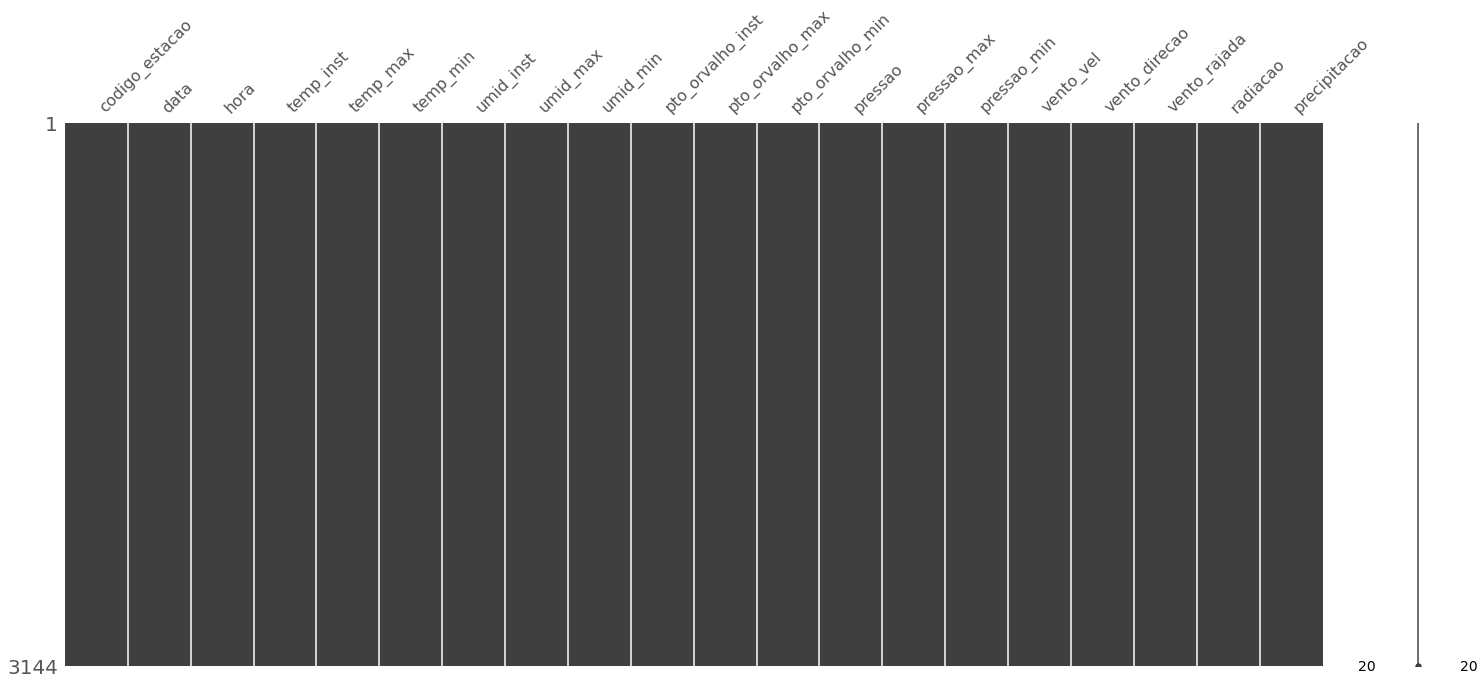

In [10]:
msno.matrix(oiapoque)

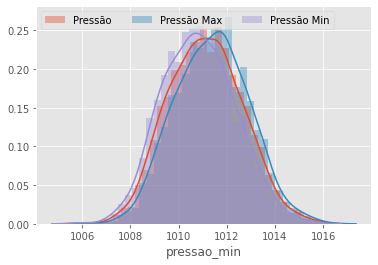

OBS:. Apos te feito alguns testes de hipotese para normalidade (na verdade fiz na EDA só pra precipitação), heatcolor de correlação e toda analise percebeu-se que as features acima são as mais importantes  

## Seleção de Features 

- Selecionando o nosso X e Y  

In [16]:
oiapoque.columns

Index(['codigo_estacao', 'data', 'hora', 'temp_inst', 'temp_max', 'temp_min',
       'umid_inst', 'umid_max', 'umid_min', 'pto_orvalho_inst',
       'pto_orvalho_max', 'pto_orvalho_min', 'pressao', 'pressao_max',
       'pressao_min', 'vento_vel', 'vento_direcao', 'vento_rajada', 'radiacao',
       'precipitacao'],
      dtype='object')

In [17]:
y = oiapoque['temp_inst'] # temperatura no instante (target)
X = oiapoque.drop(['temp_inst','codigo_estacao','data','hora'], axis=1) # removendo temperatura no instante e algumas features 

- Treino e teste

In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=0)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape 

((2200, 16), (944, 16), (2200,), (944,))

### Selecionando Features mais importante 

In [20]:
k_vs_score = []

for k in range(2,17,2): 
    selector = SelectKBest(score_func=f_regression, k=5)

    Xtrain2 = selector.fit_transform(Xtrain, ytrain)
    Xtest2 = selector.transform(Xtest)

    mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
    mdl.fit(Xtrain2, ytrain)

    prev_temp = mdl.predict(Xtest2)

    score = mean_absolute_error(ytest, prev_temp)
    print(f'k = {k} - MAE = {score}')

    k_vs_score.append(score)

k = 2 - MAE = 0.14339759887005746
k = 4 - MAE = 0.14339759887005743
k = 6 - MAE = 0.14339759887005762
k = 8 - MAE = 0.14339759887005749
k = 10 - MAE = 0.14339759887005746
k = 12 - MAE = 0.14339759887005765
k = 14 - MAE = 0.14339759887005754
k = 16 - MAE = 0.14339759887005757


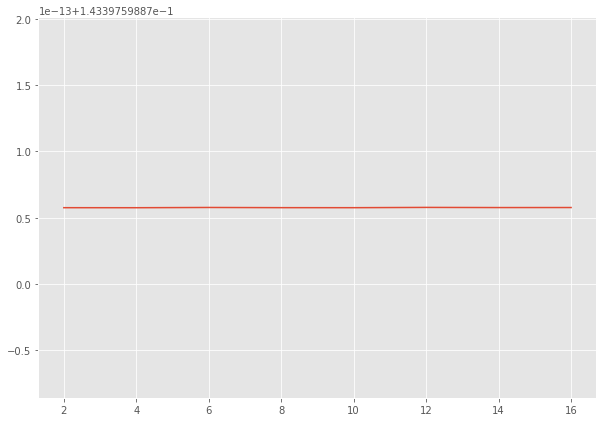

In [21]:
pd.Series(k_vs_score, index=range(2,17,2)).plot(figsize=(10,7)) # vamos printar um grafico de frequencia

In [22]:
selector = SelectKBest(score_func=f_regression, k=8) # selecionamos o intervalo
selector.fit(Xtrain, ytrain)

SelectKBest(k=8, score_func=<function f_regression at 0x7fa43b52e170>)

In [23]:
mask = selector.get_support()
Xtest.columns[mask] # vamos ver as features

Index(['temp_max', 'temp_min', 'umid_inst', 'umid_max', 'umid_min',
       'vento_vel', 'vento_rajada', 'radiacao'],
      dtype='object')

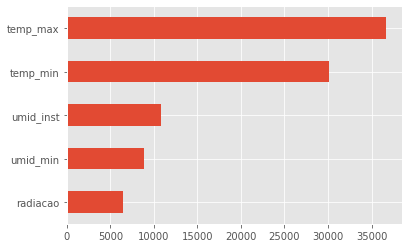

In [24]:
pd.Series(selector.scores_, index=Xtrain.columns).sort_values().tail().plot.barh()

## Avaliando o desempenho do modelo

In [25]:
print(f'𝑅² - Coeficiente de determinação: {r2_score(ytest, prev_temp).round(8)}') # 𝑅²
print(f'MSE - Erro médio quadrático: {mean_squared_error(ytest, prev_temp).round(8)}') # Mean Squared Error
print(f'MAE - Mediana dos erros de predição: {median_absolute_error(ytest, prev_temp).round(8)}') # Median Absolute Error'

𝑅² - Coeficiente de determinação: 0.99030813
MSE - Erro médio quadrático: 0.05580419
MAE - Mediana dos erros de predição: 0.075


## Salvando as Previsões

In [26]:
prev_temp_oiapoque = pd.Series(prev_temp)
prev_temp_oiapoque.to_csv('../output/prev_temp_oiapoque.csv',index = False)